## CO2RR 공정 datasheet 분석

----------------------------------

-------

Output 중 Required energy_total (MJ/kgCO), MSP 분석 예정

step0. 라이브러리 정리

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from kan import KAN
from kan.utils import ex_round
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


step1. 엑셀 파일 불러오기

In [2]:
# 엑셀 데이터 로드 
filepath = r"C:\Users\kepco201\Desktop\KAN_python\pykan-master\.github\workflows\TaeWoong\25.01.14_CO2RR_GSA.xlsx"
xls = pd.ExcelFile(filepath) 
df_in  = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')



step2.결측값 대체 및 이상치 제거

이상치(Outlier) 제거 / 전체 데이터의 10% 이내로 극소량만 제거

In [ ]:
# 이상치(Outlier) 제거 (IQR 방식) ---

print("--- 이상치 제거 시작 ---")


print(f"이상치 제거 전 데이터 수: {len(df_in)} 개")   # len(df_in) 을 통해 이상치 제거 전 데이터 길이(개수) 출력


def remove_outliers_iqr(df_in, df_out):              # outlier 제거 함수 정의
    
    combined_df = pd.concat([df_in, df_out], axis=1) # pd.concat = 2개를 합치기 // 입력 변수(X)와 출력 변수(y)를 합쳐서 전체 데이터프레임 생성 // x랑 y를 한번에 고려
                                                     # axis = 1 --- 오른쪽으로 합치기 --- 데이터 구조를 보면 예쁘게 정리가 된다
    
    numeric_cols = combined_df.select_dtypes(include=np.number).columns  # .select_dtypes 를 통해 특정 열만 출력 outlier 를 탐지할 숫자형 컬럼만 선택
                                    # numeric_cols = 숫자로만 구성된 열들의 이름 리스트 (.colums = 그 열의 이름을 리스트로 출력)

    # 각 컬럼에 대해 이상치 경계 계산 
    Q1 = combined_df[numeric_cols].quantile(0.25)   # .quantile(0.25) = 데이터를 오름차순으로 정렬했을 떄 하위 25% 지점 
    Q3 = combined_df[numeric_cols].quantile(0.75)   # .quantile(0.75) = 데이터를 오름차순으로 정렬했을 떄 상위 25% 지점 
    IQR = Q3 - Q1 # IQR은 대략 상위 25% - 상위75% = 중간정도의 값에 해당
    
    lower_bound = Q1 - 6 * IQR  # 보통은 1.5* IQR을 진행하지만 최대한 삭제되는 데이터가 적도록 진행
    upper_bound = Q3 + 6 * IQR
    

    # 밑의 줄은 공부를 더 해보자
    # 모든 컬럼에 대해 정상 범위 내에 있는 데이터만 True로 표시
    # (row의 어떤 컬럼이라도 이상치면 해당 row 전체가 False가 됨)
    condition = ~((combined_df[numeric_cols] < lower_bound) | (combined_df[numeric_cols] > upper_bound)).any(axis=1)
    

    # 정상 범위에 있는 데이터만 필터링
    df_in_no_outliers = df_in[condition]
    df_out_no_outliers = df_out[condition]
    
    return df_in_no_outliers, df_out_no_outliers

# 3. 함수를 사용하여 이상치 제거
#    이전에 결측치를 제거한 df_in_cleaned, df_out_cleaned를 사용합니다.
df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)


# 4. 이상치 제거 후 남은 데이터 개수 확인
removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")


# 이제 'df_in_final'과 'df_out_final'을 사용하자

# 으아...할 일이 많군


# 입력 변수(X) 선택 - 엑셀파일에서 불러옴
X = df_in_final[[
    "Current density (mA/cm2)", 
    "Faradaic efficiency (%)", 
    "CO coversion",
    "Voltage (V)", 
    "Electricity cost ($/kWh)", 
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", 
    "Crossover rate"
]].values

predicting = "Required energy_total (MJ/kgCO)" # 다른 output 변수 보고싶으면 이거 보면 됨 # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
###### 이거를 수정해서 다른 output도 보자

y = df_out_final[predicting].values.reshape(-1, 1)   # df_out_final[] 는 pandas datatframe이기에 이것을 skitlearn 이나 Keras 형태로 바꾸기 -- 그래야 
                                                     # .values 를 통해 Numpy 배열로 변환 (값만 뽑기 때문) # 그 후에 reshape(-1.1) 을 통해 
                                                     # .reshape()을 이용해 열 1








# 1단계: 먼저 train+val과 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2단계: train+val을 train과 val로 분할 (64:16, 전체 대비)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)


# 최종 비율 확인
# (X[:,0])~(X[:,7]) 에 각각의 입력변수들의 값들이 각각 저장됨




print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")  
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

from sklearn.preprocessing import MinMaxScaler
import numpy as np



# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))




X_train_norm = scaler_X.fit_transform(X_train) # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train) # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

# 3. 학습된 스케일러로 검증 및 테스트 데이터 변환 (transform)
# X_train의 기준으로 나머지 데이터들을 변환합니다.
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)   # y_val 과 y_test 도 y_train 의 정규분포를 따라 변환된다
y_test_norm = scaler_y.transform(y_test)

# 딥러닝을 진행하기 전 모든 데이터셋을 tensor로 변환  # 원래는 numpy 배열이었음 --- 아까 scikitlearn의 train test split 이나 .fit transform 스케일러를 사용하였기에 
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val_norm, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32, device=device)

print(f"모든 텐서가 {device}에 배치됨")

# 나중에 정의하기 편하게 dataset을 정의하기 -- 참고로 dataset들은 tensor 이다

dataset = {'train_input': X_train_tensor,'train_label': y_train_tensor,
            'val_input': X_val_tensor, 'val_label': y_val_tensor,
            'test_input': X_test_tensor,'test_label': y_test_tensor }    # dataset dictionary에 key값과 value 값을 설정한다

# 데이터셋 검토차 크기 확인
for key, value in dataset.items():                     #.items()를 쓰면 key와 value 값을 묶어서 출력 // .items()가 없으면 오직 key만 출력
    print(f"{key}: {value.shape}")


--- 이상치 제거 시작 ---
이상치 제거 전 데이터 수: 2501 개
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
--- 이상치 제거 완료 ---

전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)
모든 텐서가 cpu에 배치됨
train_input: torch.Size([1521, 8])
train_label: torch.Size([1521, 1])
val_input: torch.Size([381, 8])
val_label: torch.Size([381, 1])
test_input: torch.Size([476, 8])
test_label: torch.Size([476, 1])


### step이 많아서 따로따로 보면 피곤해서 ci 파라미터 출력할때는 아래의 step들을 합쳐서 위에 하나의 코드 칸에 써놓음

이상치 제거 후 X, Y 정의하기

step3. 엑셀 파일 속 data 추출 및 !predict 할 데이터 이름 입력!

step4. train_set, valadation_set, test_set 만들기 (64:16:20) 우측 하단 RAW로 일단 설정해놓음 나중에 python으로 바꾸기

step5. 데이터 정규화(normalization)_전처리 과정

step6. tensor 변환

step7. dataset dictionary 만들기

step8. 1개의 KAN 모델 생성

In [4]:
# KAN 모델 생성
model = KAN(width=[8,12,1], grid=3, k=3, seed=42, device=device)   

checkpoint directory created: ./model
saving model version 0.0


In [5]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"학습가능 파라미터 수: {num_params:,}")

for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name:40s} {p.shape} {p.numel():5d}")

학습가능 파라미터 수: 1,296
act_fun.0.coef                           torch.Size([8, 12, 6])   576
act_fun.0.scale_base                     torch.Size([8, 12])    96
act_fun.0.scale_sp                       torch.Size([8, 12])    96
act_fun.1.coef                           torch.Size([12, 1, 6])    72
act_fun.1.scale_base                     torch.Size([12, 1])    12
act_fun.1.scale_sp                       torch.Size([12, 1])    12
symbolic_fun.0.affine                    torch.Size([12, 8, 4])   384
symbolic_fun.1.affine                    torch.Size([1, 12, 4])    48


step9. KAN 학습

| train_loss: 2.29e-02 | test_loss: 2.56e-02 | reg: 2.80e+00 | : 100%|█| 50/50 [00:34<00:00,  1.47it


saving model version 0.1


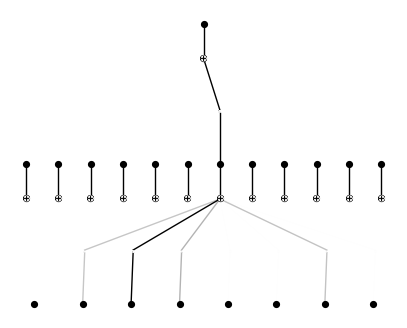

In [6]:
# KAN 학습
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001)
model.plot()

basis function에 곱해지는 파라미터 ci의 리스트를 나열해보자

In [7]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef 




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)




layer 0의 전체 ci tensor 크기 
torch.Size([8, 12, 6])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.024278614670038223, 0.03391355648636818, 0.03317160904407501, 0.03539734333753586, 0.03546876460313797, 0.04208945482969284]


In [8]:
#pruning
model = model.prune(node_th=1e-2, edge_th=3e-2)  # 더 자르고 싶으면 값을 높이고, 덜 자르고 변수를 많이 있게 하고 싶으면 값을 낮추기

#학습
model.fit(dataset, opt="LBFGS", steps=50)  # update_grid 가 False일때랑 True일때의 차이는?


saving model version 0.2


| train_loss: 1.42e-02 | test_loss: 1.46e-02 | reg: 4.30e+00 | : 100%|█| 50/50 [00:09<00:00,  5.17it

saving model version 0.3


{'train_loss': [array(0.02854487, dtype=float32),
  array(0.02030045, dtype=float32),
  array(0.01650932, dtype=float32),
  array(0.015928, dtype=float32),
  array(0.0155063, dtype=float32),
  array(0.01500452, dtype=float32),
  array(0.01458054, dtype=float32),
  array(0.01444931, dtype=float32),
  array(0.01433184, dtype=float32),
  array(0.01426433, dtype=float32),
  array(0.0142545, dtype=float32),
  array(0.01424567, dtype=float32),
  array(0.01424269, dtype=float32),
  array(0.01424005, dtype=float32),
  array(0.01423846, dtype=float32),
  array(0.01423751, dtype=float32),
  array(0.01423727, dtype=float32),
  array(0.01423714, dtype=float32),
  array(0.01423704, dtype=float32),
  array(0.01423702, dtype=float32),
  array(0.01423703, dtype=float32),
  array(0.01423703, dtype=float32),
  array(0.01423703, dtype=float32),
  array(0.01423702, dtype=float32),
  array(0.01423702, dtype=float32),
  array(0.01423702, dtype=float32),
  array(0.01423702, dtype=float32),
  array(0.01423702

In [ ]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef 




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

# 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   
print(ci_list)


layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 6])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.0026303587947040796, 0.00020170683274045587, 0.007920091971755028, 0.016294509172439575, 0.02730969898402691, 0.03752383589744568]


In [10]:
# refine(grid extension) 그리드 세분화(구간 세분화)(전체 구간 개수 30개로 변화) 
model = model.refine(30)
model.fit(dataset, opt="LBFGS", steps=50)

saving model version 0.4


| train_loss: 1.20e-02 | test_loss: 1.54e-02 | reg: 4.39e+00 | : 100%|█| 50/50 [00:43<00:00,  1.16it

saving model version 0.5


{'train_loss': [array(0.01283104, dtype=float32),
  array(0.01255229, dtype=float32),
  array(0.01234153, dtype=float32),
  array(0.01229078, dtype=float32),
  array(0.01226092, dtype=float32),
  array(0.01224875, dtype=float32),
  array(0.01222629, dtype=float32),
  array(0.01220374, dtype=float32),
  array(0.01218283, dtype=float32),
  array(0.01217049, dtype=float32),
  array(0.01216722, dtype=float32),
  array(0.01214412, dtype=float32),
  array(0.01213034, dtype=float32),
  array(0.01211906, dtype=float32),
  array(0.0121057, dtype=float32),
  array(0.01211032, dtype=float32),
  array(0.01210192, dtype=float32),
  array(0.01209358, dtype=float32),
  array(0.01208445, dtype=float32),
  array(0.01207467, dtype=float32),
  array(0.01208241, dtype=float32),
  array(0.01207406, dtype=float32),
  array(0.01206664, dtype=float32),
  array(0.01206152, dtype=float32),
  array(0.01205813, dtype=float32),
  array(0.01207759, dtype=float32),
  array(0.0120734, dtype=float32),
  array(0.012070

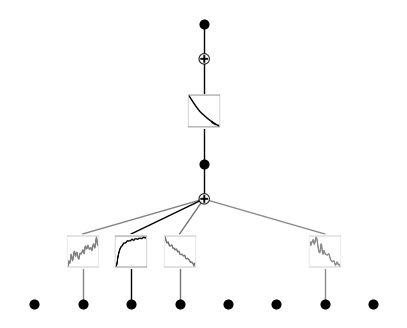

In [11]:
model.plot()

In [ ]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef 




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

# 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)


layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.0005403138929978013, 0.0010397484293207526, 0.0015770168974995613, 0.0021596229635179043, 0.002791916485875845, 0.0034631816670298576, 0.004140169359743595, 0.004809977486729622, 0.005517023615539074, 0.006275670137256384, 0.00710017466917634, 0.007920503616333008, 0.008724323473870754, 0.009555225260555744, 0.010416010394692421, 0.011286724358797073, 0.012130974791944027, 0.012983198277652264, 0.013873540796339512, 0.014798133634030819, 0.015722857788205147, 0.016655208542943, 0.017630718648433685, 0.0186722744256258, 0.019702263176441193, 0.020722797140479088, 0.021812496706843376, 0.022984100505709648, 0.02413259632885456, 0.025215504691004753, 0.026242133229970932, 0.027290726080536842, 0.02831258997321129]


step11. KAN symbolification

fixing (0,0,0) with 0
fixing (0,1,0) with x, r2=0.8129587173461914, c=1
fixing (0,2,0) with exp, r2=0.9851700067520142, c=2
fixing (0,3,0) with x, r2=0.9893946647644043, c=1
fixing (0,4,0) with 0
fixing (0,5,0) with 0
fixing (0,6,0) with x, r2=0.9063552021980286, c=1
fixing (0,7,0) with 0
fixing (1,0,0) with x, r2=0.9743391275405884, c=1
saving model version 0.6


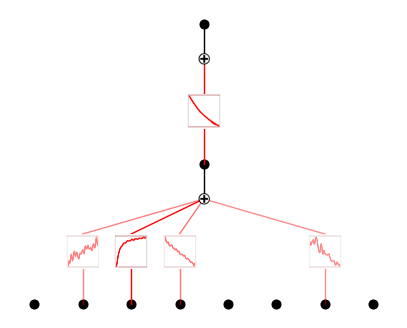

In [13]:
# 자동 모드로 심볼릭 회귀 수행
lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin']   #'x^(-1)', 'x^(-2)', 'x^(-3)', 'x^(-4)'
model.auto_symbolic(lib=lib)
model.plot()

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 2.67e-02 | test_loss: 2.65e-02 | reg: 0.00e+00 | : 100%|█| 50/50 [00:10<00:00,  4.76it


saving model version 0.7


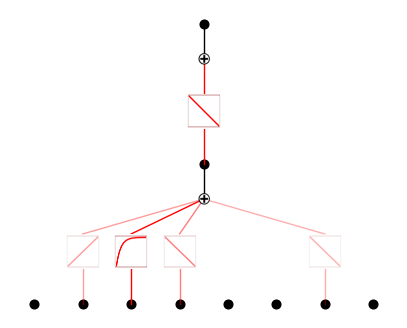

In [14]:
# symbolic 함수로 대체 후 학습
model.fit(dataset, opt="LBFGS", steps=50)
model.plot()

ci 계수들 출력하기

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.0005405393894761801, 0.001039710477925837, 0.0015770294703543186, 0.0021596138831228018, 0.002791923237964511, 0.0034631795715540648, 0.004140171688050032, 0.004809975624084473, 0.0055170184932649136, 0.006275685969740152, 0.007100149057805538, 0.007920543663203716, 0.00872432067990303, 0.00955523457378149, 0.010416002944111824, 0.011286732740700245, 0.012130960822105408, 0.012983204796910286, 0.01387354452162981, 0.014798165298998356, 0.015722857788205147, 0.016655191779136658, 0.017630714923143387, 0.018672307953238487, 0.019702209159731865, 0.02072283625602722, 0.021812450140714645, 0.022984130308032036, 0.024132542312145233, 0.02521556057035923, 0.0262420903891325, 0.027290696278214455, 0.02831263095140457]


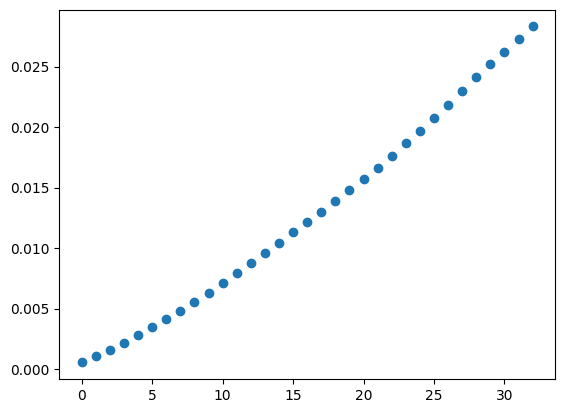

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 0
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 1 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.12944549322128296, 0.05991590768098831, 0.026463836431503296, 0.024471553042531013, 0.06239429861307144, 0.004540968220680952, 0.03402234613895416, 0.04368183761835098, 0.005771588999778032, 0.024654602631926537, 0.016942262649536133, -0.006050033960491419, -0.019749224185943604, 0.00226130080409348, -0.01870831288397312, -0.010858915746212006, -0.012385634705424309, -0.04506797716021538, -0.01045726053416729, -0.028557468205690384, -0.04324791952967644, -0.02882838249206543, -0.05257466435432434, -0.06652707606554031, -0.06106916069984436, -0.09166277945041656, -0.07406787574291229, -0.07369314134120941, -0.10584952682256699, -0.09077756851911545, -0.06539136916399002, -0.1413004994392395, -0.060116443783044815]


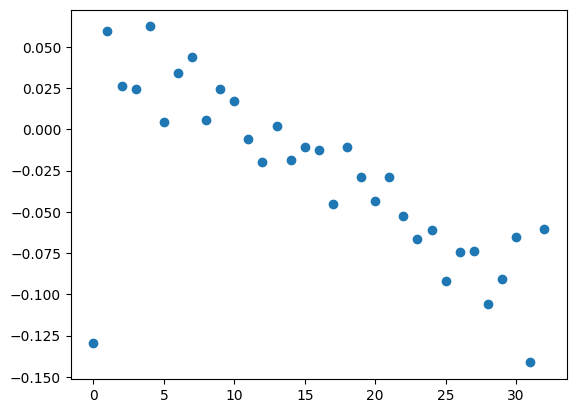

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 1
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 2 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.022783886641263962, -0.03138000890612602, 0.046433791518211365, 0.08036966621875763, 0.10291045159101486, 0.1130087748169899, 0.1145600825548172, 0.11302315443754196, 0.12739761173725128, 0.11628871411085129, 0.10943055152893066, 0.10661845654249191, 0.11297692358493805, 0.09697680920362473, 0.09119292348623276, 0.07875756919384003, 0.07911410182714462, 0.07639241963624954, 0.05894745886325836, 0.04331905022263527, 0.05103359743952751, 0.038211461156606674, 0.028248470276594162, 0.010179659351706505, 0.00932244211435318, -0.0033281142823398113, -0.014865766279399395, -0.033349424600601196, -0.03501768037676811, -0.044721946120262146, -0.05898940935730934, -0.07966688275337219, -0.048066988587379456]


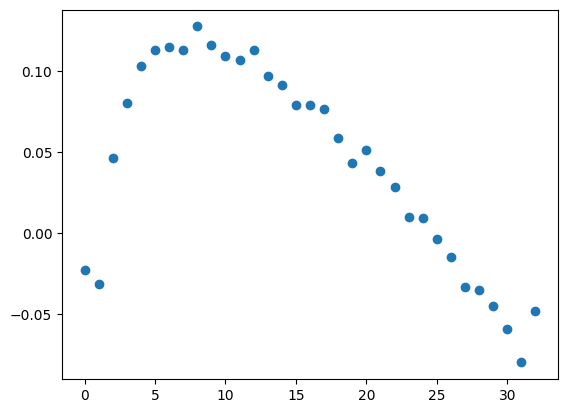

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 2
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 3 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.013944029808044434, -0.07285895943641663, -0.0772293284535408, -0.08126860857009888, -0.06234980747103691, -0.07910923659801483, -0.07313647866249084, -0.06413222849369049, -0.053860217332839966, -0.06812357902526855, -0.0529625304043293, -0.060414932668209076, -0.04520600289106369, -0.041988857090473175, -0.049028489738702774, -0.029151946306228638, -0.04270428046584129, -0.030531806871294975, -0.025273730978369713, -0.019074993208050728, -0.019217001274228096, -0.001749671995639801, -0.011023100465536118, -0.006343092303723097, 0.007211958058178425, 0.00782306119799614, 0.01663477160036564, 0.010891894809901714, 0.027824649587273598, 0.02888120710849762, 0.0339537039399147, 0.02596312202513218, 0.14055684208869934]


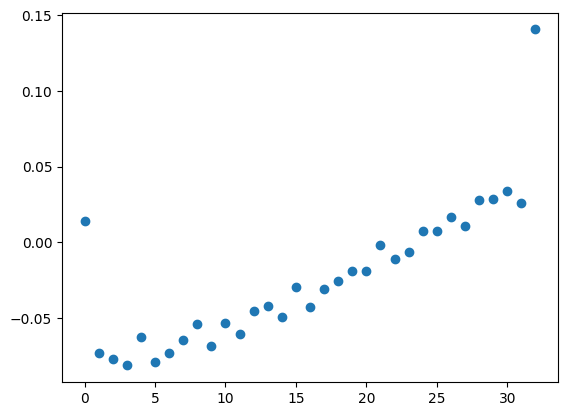

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 3
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 4 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.026558006182312965, -0.02717183530330658, -0.027493653818964958, -0.027581628412008286, -0.02746758423745632, -0.027186179533600807, -0.02679881639778614, -0.026331527158617973, -0.025817906484007835, -0.02522197552025318, -0.024595284834504128, -0.023996010422706604, -0.02345343865454197, -0.02292577177286148, -0.02241639420390129, -0.021948881447315216, -0.021482855081558228, -0.021011080592870712, -0.020519323647022247, -0.020027078688144684, -0.01951812207698822, -0.019001612439751625, -0.018472153693437576, -0.017905954271554947, -0.017317404970526695, -0.01670694164931774, -0.016135921701788902, -0.015591932460665703, -0.015085332095623016, -0.014622117392718792, -0.014229433611035347, -0.013911780901253223, -0.013672791421413422]


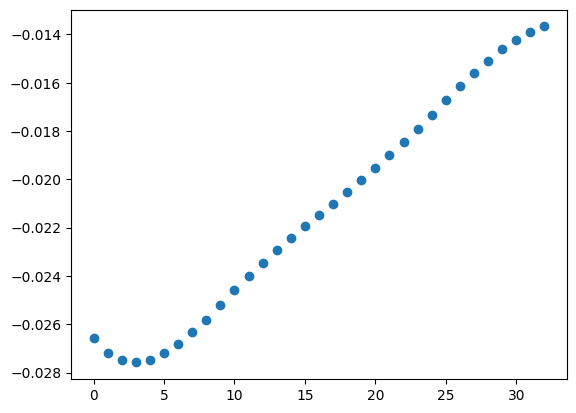

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 4
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 5 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.013014933094382286, 0.011020324192941189, 0.009204684756696224, 0.007599281147122383, 0.006166017614305019, 0.004912343807518482, 0.0037968135438859463, 0.0027954219840466976, 0.0018401335692033172, 0.0008637140854261816, -0.00010337436106055975, -0.0011042187688872218, -0.002136870054528117, -0.003280240809544921, -0.004417765885591507, -0.005582519341260195, -0.0067999884486198425, -0.008080723695456982, -0.009376011788845062, -0.010700630955398083, -0.0120626762509346, -0.013484698720276356, -0.01490394864231348, -0.016514699906110764, -0.018295006826519966, -0.020110270008444786, -0.021830542013049126, -0.02341696433722973, -0.024860478937625885, -0.02612018585205078, -0.027306823059916496, -0.028429832309484482, -0.029480313882231712]


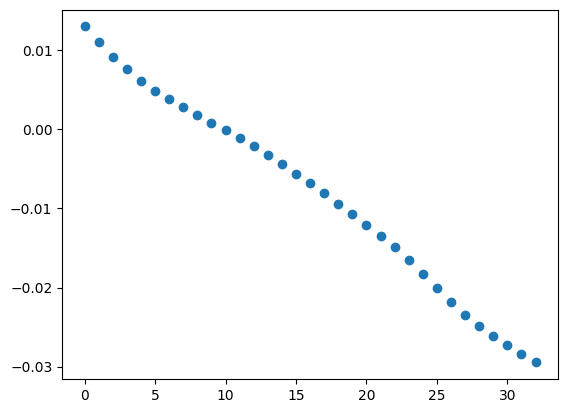

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 5
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 6 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.061928316950798035, -0.07068690657615662, -0.03439216688275337, -0.04296380281448364, -0.022153958678245544, -0.045073382556438446, -0.025193845853209496, -0.011738409288227558, -0.017436755821108818, -0.034004274755716324, -0.043463729321956635, -0.045342184603214264, -0.009704654105007648, -0.02097189426422119, -0.04382925480604172, -0.017963610589504242, -0.027601266279816628, -0.02594071812927723, -0.023496707901358604, -0.02173774689435959, -0.011154942214488983, -0.01686748117208481, -0.0222619641572237, -0.020299069583415985, -0.019566679373383522, -0.009759186767041683, -0.011987794190645218, -0.01875629462301731, -0.0013829243835061789, 0.0008790521533228457, -0.004493808839470148, 0.008733393624424934, -0.025004500523209572]


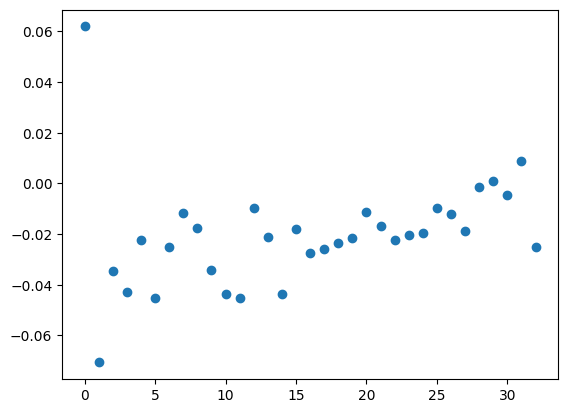

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 6
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 7 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.02187355048954487, -0.02069971337914467, -0.01925763115286827, -0.017644157633185387, -0.01582682691514492, -0.013885874301195145, -0.011807664297521114, -0.009745477698743343, -0.007695541717112064, -0.005409967619925737, -0.00295729236677289, -0.00031422669417224824, 0.00217488594353199, 0.004727315157651901, 0.007169051561504602, 0.009838857688009739, 0.012525428086519241, 0.015225153416395187, 0.01781892403960228, 0.02040674351155758, 0.023049283772706985, 0.025584910064935684, 0.02812786027789116, 0.030683577060699463, 0.03332813084125519, 0.036124903708696365, 0.038880255073308945, 0.04172446206212044, 0.044526711106300354, 0.04758770391345024, 0.05082406848669052, 0.054185714572668076, 0.05755050480365753]


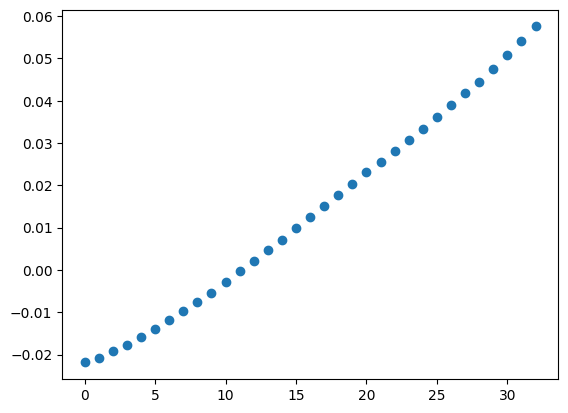

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 7
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 1의 전체 ci tensor 크기 
torch.Size([1, 1, 33])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.817493736743927, 0.7024959921836853, 0.5643433928489685, 0.42816033959388733, 0.37100154161453247, 0.3273465633392334, 0.2921420931816101, 0.2639874219894409, 0.24436065554618835, 0.23133809864521027, 0.21298165619373322, 0.21510596573352814, 0.18082153797149658, 0.2208038717508316, 0.1666269451379776, 0.185246542096138, 0.19596050679683685, 0.15387532114982605, 0.176351860165596, 0.17997008562088013, 0.14459531009197235, 0.16583183407783508, 0.17102999985218048, 0.14531585574150085, 0.13559888303279877, 0.16217532753944397, 0.1427122801542282, 0.13066771626472473, 0.1522843837738037, 0.1231406033039093, 0.13587281107902527, 0.11150899529457092, 0.09085248410701752]


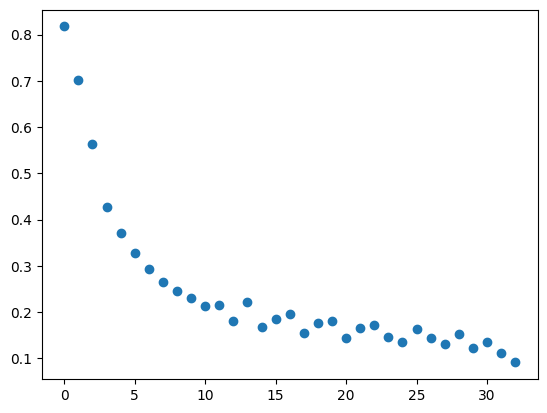

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 1
input_node_index = 0
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

step12. symbolic 수식 출력

In [23]:
# 심볼릭 수식 출력
formula = ex_round(model.symbolic_formula()[0][0], 4)  # ex_round(  , 4) -- 소수점 뒤에 숫자 4개? // 
print("formula =" , formula)  
print('(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)')


formula = -0.0763*x_2 + 0.105*x_4 + 0.0602*x_7 + 0.1107 + 1.2667*exp(-8.2912*x_3)
(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)


step13. KAN이 예측한 수식 정확도 검증을 위한 함수 정의

In [24]:
# validation set으로 성능을 평가하는 함수 만들기
def evaluate_model_performance(model, dataset, scaler_y, phase="validation"):    # phase = validation 아니면 test 이다
    
    
    if phase == "validation":
        input_tensor = dataset['val_input']
        label_tensor = dataset['val_label']
    elif phase == "test":
        input_tensor = dataset['test_input']
        label_tensor = dataset['test_label']
    else:
        raise ValueError("phase는 'validation' 또는 'test'만 가능합니다")
    
    # 예측 수행
    with torch.no_grad():  # 굳이 기울기 계산할 필요 X because 이거는 test 이기에 학습 X --- 시간 더 빠르게 하려고 torch.no_grad()
        pred_norm = model(input_tensor) #input_tensor 는 val_inut or test_input / pred_norm은 그에 대한 출력값
    
    # 역정규화
    pred_real = scaler_y.inverse_transform(pred_norm.cpu().detach().numpy())   # pred_real 은 0.1~0.9 사이의 입력 val_input or test_input을 받고 출력된 값은 다시 역정규화 한 실제 출력값
    label_real = scaler_y.inverse_transform(label_tensor.cpu().detach().numpy()) # label_real은 0.1~0.9 사이의 입력 val_label or test_label을 받고 출력한 값 역정규화
    # inverse_transform 함수는  numpy 를 입력으로 받기 떄문에 pytorch tensor를 cpu로 옮기고 numpy로 변환
    
    # numpy는 cpu에서만 돌아가니까 tensor를 .cpu로 옮기고 그다음 tensor의 추가정보 (numpy 정보 + 어떻게 계산되었는지 식에 대한 정보)를 detach --- 그 다음에 .numpy()를 통해 numpy로 변환
    
    # 성능 지표 계산 from 역정규화된 label_real, pred_real 값들 from val input or test input + numpy에서 계산
    rmse = np.sqrt(mean_squared_error(label_real, pred_real))  # 오차 제곱 평균의 루트
    r2 = r2_score(label_real, pred_real)  #1에 가까울수록 좋다 
    mae = np.mean(np.abs(label_real - pred_real)) # 오차 절댓값들의 평균 -- MAE
    
    print(f"{phase} SET Performance Evaluation") # phase = validation 또는 test 
    print(f"RMSE: {rmse:.4f}")     # f"{변수:포맷코드}"
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    print(f"실제값 평균: {label_real.mean():.4f}")  #label_real의 평균값(실제값)
    print(f"예측값 평균: {pred_real.mean():.4f}")   #pred_real의 평균값(KAN 모델로 예측한 값)
    
    return pred_real, label_real, {'rmse': rmse, 'r2': r2, 'mae': mae}

Step14. Validation data(검증셋)으로 성능 평가

In [25]:
# validation dataset(검증셋)으로 성능 평가 (모델 개발 과정에서)
val_pred, val_actual, val_metrics = evaluate_model_performance(model, dataset, scaler_y, "validation")

#scaler_y : step5 에서 정의한 정규화된 y 변환법
# validation --- 검증셋 이용할거라는 의미 / 나중에 
# val_pred 변수: evaluate_model_performance 함수가 반환한 첫 번째 결과물(pred_real)(모델의 예측값 배열)이 저장
# val_actual 변수: 함수가 반환한 두 번째 결과물(label_real)(실제 정답 값 배열)이 저장
# val_metrics 변수: 함수가 반환한 세 번째 결과물(RMSE, R², MAE가 담긴 딕셔너리)이 저장


validation SET Performance Evaluation
RMSE: 6.8124
R²: 0.9607
MAE: 4.1235
실제값 평균: 48.6630
예측값 평균: 48.4384


step15. KAN이 예측한 수식의 정확도 최종계산 _ using test_input, test_label

In [26]:
# 모든 모델 개발이 완료된 후 최종 한 번만 수행
print("최종 테스트셋 평가")


# 최종 테스트셋 평가(phase만 'test'로 변경하여 테스트 데이터를 사용)(이전에 정의한 evaluate_model_performance 함수를 그대로 사용)
test_pred, test_actual, test_metrics = evaluate_model_performance(
    model, dataset, scaler_y, "test"
)

# test_pred : 모델의 예측값 , test_actual : 실제 정답 값 배열 , test_metrics : (RMSE, R², MAE가 담긴 딕셔너리)

print(f"\nFinal model performance evaluation:")
print(f"Test set RMSE: {test_metrics['rmse']:.4f}")
print(f"Test set R²: {test_metrics['r2']:.4f}")
print(f"Test set MAE: {test_metrics['mae']:.4f}")


최종 테스트셋 평가
test SET Performance Evaluation
RMSE: 6.7273
R²: 0.9594
MAE: 4.1934
실제값 평균: 50.3135
예측값 평균: 50.6563

Final model performance evaluation:
Test set RMSE: 6.7273
Test set R²: 0.9594
Test set MAE: 4.1934


step16. KAN 예측값 / 실제값 그래프

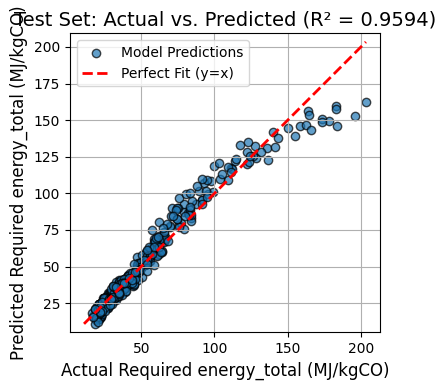

In [27]:
# step14. KAN 예측값 / 실제값 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))  # 도화지 그리기~

# test_actual (x축) vs test_pred (y축) , alpha = 투명도
plt.scatter(test_actual, test_pred, alpha=0.7, edgecolors='k', label='Model Predictions')

# 제일 작은 값, 제일 큰 값 설정
min_val = min(test_actual.min(), test_pred.min())
max_val = max(test_actual.max(), test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit (y=x)')  # y = x 선긋기

# 그래프 제목과 축 레이블 설정
plt.xlabel("Actual " + predicting , fontsize=12)   # Actual 다음에 우리가 보고자 하는 output predicting 변수가 뜸
plt.ylabel("Predicted " + predicting, fontsize=12) # 
plt.title(f'Test Set: Actual vs. Predicted (R² = {test_metrics["r2"]:.4f})', fontsize=14)
plt.legend()
plt.grid(True)  # 격자 on 
plt.axis('equal') # x, y축 스케일을 동일하게 설정
plt.tight_layout()
plt.show()


잔차 플롯 (Residual Plot): 모델의 예측 오차 패턴 분석

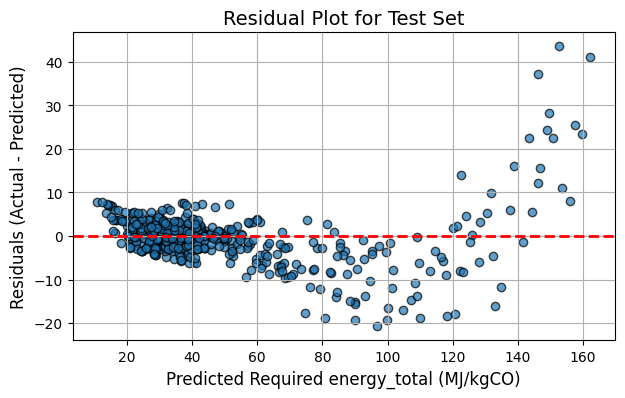

In [28]:
# 1. 잔차 계산 (실제값 - 예측값)
residuals = test_actual - test_pred

# 2. 잔차 플롯 시각화
plt.figure(figsize=(7, 4))

# x축은 예측값, y축은 잔차
plt.scatter(test_pred, residuals, alpha=0.7, edgecolors='k')

# y=0 기준선 추가 (오차가 0인 선)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

plt.xlabel("Predicted "+predicting, fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Residual Plot for Test Set', fontsize=14)
plt.grid(True)
plt.show()


2. 개별 변수 영향도 플롯 (Partial Dependence Plot): 변수-결과 관계 시각화

--- 모든 입력 변수에 대한 개별 영향도 플롯 ---


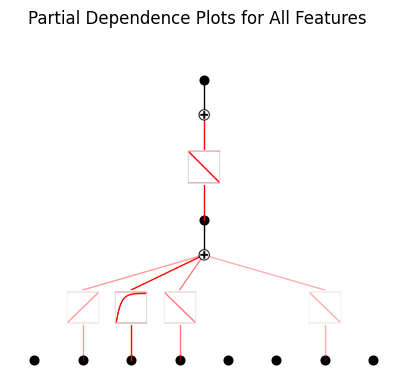

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 1. (NameError 해결) feature_names 리스트를 먼저 정의합니다.
feature_names = [
    "Current density", "Faradaic efficiency", "CO coversion", "Voltage",
    "Electricity cost", "Membrain cost", "Capture energy", "Crossover rate"
]

try:
    print("--- 모든 입력 변수에 대한 개별 영향도 플롯 ---")
    
    # 2. (TypeError 해결) 'vars' 인자 없이 plot() 함수를 호출합니다.
    # 이렇게 하면 8개 변수 각각에 대한 영향도 그래프가 한 번에 그려집니다.
    model.plot()
    
    # 전체 그래프에 대한 제목 설정 (선택 사항)
    plt.suptitle('Partial Dependence Plots for All Features', y=1.02)
    plt.show()

except Exception as e:
    print(f"오류가 발생했습니다: {e}")
    print("이전 단계에서 'model' 객체가 성공적으로 생성되었는지 확인해주세요.")



In [30]:
# step11의 코드를 다시 실행
formula = ex_round(model.symbolic_formula()[0][0], 4)
print("formula=", formula)

# 여기서 맨 왼쪽부터  x_1부터 x_8 


formula= -0.0763*x_2 + 0.105*x_4 + 0.0602*x_7 + 0.1107 + 1.2667*exp(-8.2912*x_3)


-------

------

------------------------------------------------------------------------------------------------------------------------------------------------